# MLR - Multi-Linear Regression model
- **target**: spco2
- **features**: [sst, sss, chl, mld, xco2]


In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", 100)

## Define useful functions

In [2]:
import xarray as xr
from skimage.filters import sobel

def network_mask():
    '''network_mask
    This masks out regions in the 
    NCEP land-sea mask (https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html)
    to define the open ocean. Regions removed include:
    - Coast : defined by sobel filter
    - Batymetry less than 100m
    - Arctic ocean : defined as North of 79N
    - Hudson Bay
    - caspian sea, black sea, mediterranean sea, baltic sea, Java sea, Red sea
    '''
    ### Load obs directory
    dir_obs = '/local/data/artemis/observations'
    
    ### topography
    ds_topo = xr.open_dataset(f'{dir_obs}/GEBCO_2014/processed/GEBCO_2014_1x1_global.nc')
    ds_topo = ds_topo.roll(lon=180, roll_coords='lon')
    ds_topo['lon'] = np.arange(0.5, 360, 1)

    ### Loads grids
    # land-sea mask
    # land=0, sea=1
    ds_lsmask = xr.open_dataset(f'{dir_obs}/masks/originals/lsmask.nc').sortby('lat').squeeze().drop('time')
    data = ds_lsmask['mask'].where(ds_lsmask['mask']==1)
    ### Define Latitude and Longitude
    lon = ds_lsmask['lon']
    lat = ds_lsmask['lat']
    
    ### Remove coastal points, defined by sobel edge detection
    coast = (sobel(ds_lsmask['mask'])>0)
    data = data.where(coast==0)
    
    ### Remove shallow sea, less than 100m
    ### This picks out the Solomon islands and Somoa
    data = data.where(ds_topo['Height']<-100)
    
    ### remove arctic
    data = data.where(~((lat>79)))
    data = data.where(~((lat>67) & (lat<80) & (lon>20) & (lon<180)))
    data = data.where(~((lat>67) & (lat<80) & (lon>-180+360) & (lon<-100+360)))

    ### remove caspian sea, black sea, mediterranean sea, and baltic sea
    data = data.where(~((lat>24) & (lat<70) & (lon>14) & (lon<70)))
    
    ### remove hudson bay
    data = data.where(~((lat>50) & (lat<70) & (lon>-100+360) & (lon<-70+360)))
    data = data.where(~((lat>70) & (lat<80) & (lon>-130+360) & (lon<-80+360)))
    
    ### Remove Red sea
    data = data.where(~((lat>10) & (lat<25) & (lon>10) & (lon<45)))
    data = data.where(~((lat>20) & (lat<50) & (lon>0) & (lon<20)))
    
    return data

## Load data

In [3]:
# Data directory
# This is pre-processed data
dir_data='/local/data/artemis/observations/neural_net_data'

# Observations dictionary
dict_data = {'spco2': f'{dir_data}/spco2_1x1_mon_SOCATv2019_199801-201712.nc', 
             'sst': f'{dir_data}/sst_1x1_mon_NOAAOIv2_199801-201712.nc',
             'sss': f'{dir_data}/sss_1x1_mon_EN421_199801-201712.nc',
             'chl': f'{dir_data}/chl_1x1_mon_globColour_199801-201712.nc',
             'mld': f'{dir_data}/mld_1x1_clim_deBoyer_199801-201712.nc',
             'xco2': f'{dir_data}/xco2_1x1_mon_globalview_199801-201712.nc'}

###  Load all variables into common dataset
ds = xr.merge([xr.open_dataset(dict_data['sst']),
               xr.open_dataset(dict_data['sss']),
               xr.open_dataset(dict_data['chl']),
               xr.open_dataset(dict_data['mld']),
               xr.open_dataset(dict_data['xco2']),
               xr.open_dataset(dict_data['spco2'])])

## Mask data

In [4]:
# Define my network mask
mask = network_mask()

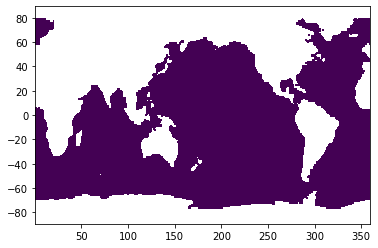

In [5]:
plt.pcolor(mask['lon'], mask['lat'], mask)

In [6]:
# Apply mask to dataset
ds = ds.where(mask==1)

## Put into dataframe

In [7]:
### Put data into dataframe 
df = ds.to_dataframe().reset_index()

### select variables and drop nans 
df.dropna(subset=['lon', 'lat', 'time',
                  'sst', 'sss', 
                  'chl', 'mld', 
                  'xco2', 'spco2'], inplace=True)

In [8]:
df.head()

,lat,lon,time,sst,sss,chl,mld,xco2,spco2
1162620,-76.5,164.5,2003-01-15,-0.94,34.160316,0.314534,18.729113,374.796520,278.475037
1162632,-76.5,164.5,2004-01-15,-0.82,34.143547,0.356009,18.729113,376.998760,213.402817
1162633,-76.5,164.5,2004-02-15,-0.88,33.959709,0.763949,23.885191,377.540533,199.720215
1162669,-76.5,164.5,2007-02-15,-0.37,33.936447,0.395035,23.885191,383.332733,190.667770
1162680,-76.5,164.5,2008-01-15,-0.87,33.994492,0.665366,18.729113,384.997100,201.477844


## Train / validation / test split

In [9]:
# Input features
features = ['sst', 'sss', 'chl', 'mld', 'xco2']
features_plus_coords = ['time', 'lon', 'lat', 'sst', 'sss', 'chl', 'mld', 'xco2']

In [10]:
# Input and Output
X = df.loc[:, features] 
y = df.loc[:,'spco2']

# Uses train_test_split build into sklearn.model_selection
# By default this method shuffles the data (30% = testing 70%=training/validation)
# Train  = 49% - Valid  = 21% - Test   = 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 73)

# Select features for training
X_train_ready = X_train[features]
X_train_ready = X_train_ready.values
y_train_ready = y_train.values

# Select features for testing
X_test_ready = X_test[features]
X_test_ready = X_test_ready.values
y_test_ready = y_test.values

# Print shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(140916, 5) (140916,)
(60393, 5) (60393,)


In [11]:
### make sure there are no nans anywhere
print('NaNs in X_train_ready:', np.isnan(X_train_ready).sum())
print('NaNs in y_train_ready:', np.isnan(y_train_ready).sum())

#print('NaNs in X_val_ready:', np.isnan(X_val_ready).sum())
#print('NaNs in y_val_ready:', np.isnan(y_val_ready).sum())

print('NaNs in X_test_ready:', np.isnan(X_test_ready).sum())
print('NaNs in y_test_ready:', np.isnan(y_test_ready).sum())

NaNs in X_train_ready: 0
NaNs in y_train_ready: 0
NaNs in X_test_ready: 0
NaNs in y_test_ready: 0


# MLR model

In [12]:
reg = LinearRegression().fit(X_train_ready, y_train_ready)

In [13]:
# Evaluation scores
y_pred = reg.predict(X_test_ready)
rmse = mean_squared_error(y_test_ready, y_pred) ** 0.5
r2 = reg.score(X_test_ready, y_test_ready)
print(f'rmse = {rmse}  - R2 = {r2}')

rmse = 32.4433178774988  - R2 = 0.17424438106693008


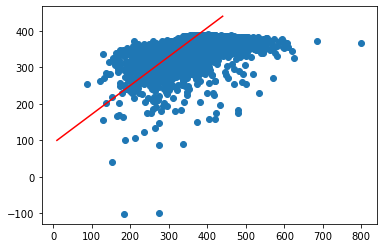

In [14]:
plt.scatter(y_test_ready, y_pred)
plt.plot([10, 440],[100, 440],'r')

## Put predictions back to make a map

In [15]:
# Latitude, longitude vectors
lon = ds['lon']
lat = ds['lat']
time = ds['time']

# create a time,lat,lon skeleton
skeleton_xr = ds.to_dataframe().reset_index()
skeleton_xr = skeleton_xr[['time','lat','lon']]

# Make predictions - to final dataframe to be aware of coords
df_all = ds.to_dataframe().reset_index()
df_all = df_all[features_plus_coords].dropna()
y_pred = reg.predict(df_all[features])

# Put preidctionsinto dataframe
df_all['spco2_pred'] = y_pred

# merge the predictions into skeleton on the time, lat, lon coords
output = skeleton_xr.merge(df_all[['time', 'lat', 'lon', 'spco2_pred']], 
                           how = 'left', on = ['time','lat','lon'])

# Reshape output to (lat, lon, time)
dim_time, dim_lat, dim_lon = ds['spco2'].shape
out = output['spco2_pred'].values.reshape(dim_lat, dim_lon, dim_time)

# Put into xarray dataset
ds_out = xr.Dataset(
    {
    'spco2':(['lat', 'lon', 'time'], out),
    # 'error':(['lat', 'lon', 'time'], error),
    },

    coords={
    'time': (['time'], time),
    'lat': (['lat'], lat),
    'lon': (['lon'], lon),
    })

## Test plot

/home/gloege/miniconda3/envs/tensorflow/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


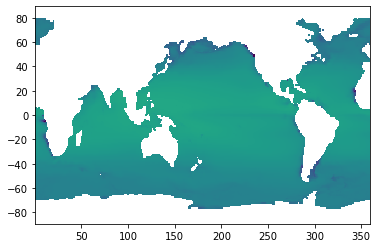

In [16]:
plt.pcolor(ds_out['lon'], ds['lat'], ds_out['spco2'].mean('time'), vmin=280, vmax=440)

# Code Snippets
- these may be useful later

In [ ]:
# Define functions
def transform_doy(obj, dim='time'):
    '''
    transform_doy(ds, dim='time')
    transform DOY into repeating cycles
    
    reference
    ==========
    Gregor et al. 2019 
    '''
    obj['T0'] = np.cos(obj[f'{dim}.dayofyear'] * 2 * np.pi / 365)
    obj['T1'] = np.sin(obj[f'{dim}.dayofyear'] * 2 * np.pi / 365)
    return obj[['T0','T1']]

def compute_n_vector(obj, dim_lon='lon', dim_lat='lat'):
    '''
    compute_n_vector(ds,dim_lon='lon', dim_lat='lat')
    calculate n-vector from lat/lon
    
    reference
    ==========
    Gregor et al. 2019 
    '''
    ### convert lat/lon to radians
    obj['lat_rad'], obj['lon_rad'] = np.radians(obj[dim_lat]), np.radians(obj[dim_lon])

    ### Calculate n-vector
    obj['A'], obj['B'], obj['C'] = np.sin(obj['lat_rad']), \
                            np.sin(obj['lon_rad'])*np.cos(obj['lat_rad']), \
                            -np.cos(obj['lon_rad'])*np.cos(obj['lat_rad'])
    return obj[['A','B','C']]

In [ ]:
features = ['sst', 'sss', 'chl', 'mld', 'xco2']
### Features (These will be features to the input)
X = df.loc[:,features] 

### Target (This is what the network is trying to learn)
y = df.loc[:,'spco2']

### Uses train_test_split build into sklearn.model_selection
### By default this method shuffles the data (30% = testing 70%=training/validation)
### Train  = 49%
### Valid  = 21%
### Test   = 30%
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.3, random_state= 73)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.3, random_state = 28)
del X_tmp
del y_tmp

#features = ['sst', 'sss', 'chl', 'mld', 'xco2']
#feature_cols = ['SST_detrend','SSS','XMLD','Chl','T0','T1','A','B','C']

### Select features for training
X_train_ready = X_train[features]
X_train_ready = X_train_ready.values
y_train_ready = y_train.values

### Select features for validation
X_val_ready = X_val[features]
X_val_ready = X_val_ready.values
y_val_ready = y_val.values

### Select features for testing
X_test_ready = X_test[features]
X_test_ready = X_test_ready.values
y_test_ready = y_test.values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#ds_trim = xr.merge([ds, ## Standard variables
#                    detrend(ds['SST'], dim='time').rename('SST_detrend'),
#                    transform_doy(ds),           ## time transormation
#                    compute_n_vector(ds)])       ## n-vector